# K-Nearest Neighbors

In [6]:
import sys 
sys.path.append('..')


import pandas as pd
from helpers.lift import area_ratio, area_ratio_scorer, plot_lift_chart


df = pd.read_csv('../data/engineered.csv')
df.head()

,Unnamed: 0,X1,X3,X5,X6,X7,X8,X9,X10,X11,...,payment_total,payment_avg,payment_std,payment_max,payment_min,payment_growth,payment_trend,payment_zero_count,payment_all_zero,payment_low_count
0,0,20000,2,24,2,2,-1,-1,-2,-2,...,689,114.833336,281.28308,689,0,0,59.057144,5,0,6
1,1,120000,2,26,-1,2,0,0,0,2,...,5000,833.333300,752.77264,2000,0,-2000,-200.000000,2,0,2
2,2,90000,2,34,0,0,0,0,0,0,...,11018,1836.333400,1569.81540,5000,1000,-3482,-454.571440,0,0,0
3,3,50000,2,37,0,0,0,0,0,0,...,8388,1398.000000,478.05817,2019,1000,1000,227.142850,0,0,0
4,4,50000,2,57,-1,0,-1,0,0,0,...,59049,9841.500000,13786.23000,36681,679,1321,3302.314200,0,0,2


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split

X = df.drop(['Y'], axis=1)
y = df['Y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
import numpy as np

knn_pipeline = Pipeline([
    ("scaler", RobustScaler()),
    ("knn_clf", KNeighborsClassifier())
])

# Random distributions / options to sample
param_distributions_knn = {
    "knn_clf__n_neighbors": sp_randint(3, 201),   # 3..200
    "knn_clf__weights": ["uniform", "distance"],
    "knn_clf__algorithm": ["ball_tree", "kd_tree", "brute", "auto"],
    "knn_clf__leaf_size": sp_randint(10, 51),     # 10..50
    "knn_clf__p": [1, 2],                          # Manhattan vs Euclidean
    "knn_clf__metric": ["minkowski"],
}

random_search = RandomizedSearchCV(
    estimator=knn_pipeline,
    param_distributions=param_distributions_knn,
    n_iter=100,                # try 100 random combos (tune up/down for speed/quality)
    scoring=area_ratio_scorer, # your custom scorer
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42,
    error_score=np.nan
)

random_search.fit(X_train, y_train)

print("Best params:", random_search.best_params_)
print("Best CV Area Ratio:", random_search.best_score_)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END knn_clf__algorithm=brute, knn_clf__leaf_size=38, knn_clf__metric=minkowski, knn_clf__n_neighbors=17, knn_clf__p=1, knn_clf__weights=distance; total time=   3.1s
[CV] END knn_clf__algorithm=brute, knn_clf__leaf_size=38, knn_clf__metric=minkowski, knn_clf__n_neighbors=17, knn_clf__p=1, knn_clf__weights=distance; total time=   3.2s
[CV] END knn_clf__algorithm=brute, knn_clf__leaf_size=38, knn_clf__metric=minkowski, knn_clf__n_neighbors=17, knn_clf__p=1, knn_clf__weights=distance; total time=   3.2s
[CV] END knn_clf__algorithm=brute, knn_clf__leaf_size=38, knn_clf__metric=minkowski, knn_clf__n_neighbors=17, knn_clf__p=1, knn_clf__weights=distance; total time=   3.3s
[CV] END knn_clf__algorithm=brute, knn_clf__leaf_size=38, knn_clf__metric=minkowski, knn_clf__n_neighbors=17, knn_clf__p=1, knn_clf__weights=distance; total time=   3.4s
[CV] END knn_clf__algorithm=brute, knn_clf__leaf_size=20, knn_clf__metric=minkowski, kn

Best params: {'knn_clf__algorithm': 'auto', 'knn_clf__leaf_size': 44, 'knn_clf__metric': 'minkowski', 'knn_clf__n_neighbors': 194, 'knn_clf__p': 1, 'knn_clf__weights': 'distance'}
Best CV Area Ratio: 0.5392507657972037

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline

optimal_knn_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('knn_clf', KNeighborsClassifier(
                                    n_neighbors=194,
                                    leaf_size=44,
                                    metric='minkowski',
                                    algorithm='auto',
                                    weights='distance',
                                    p=1
                                    )
    )
])

optimal_knn_pipeline.fit(X_train, y_train)

,steps,"[('scaler', ...), ('knn_clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,with_centering,True
,with_scaling,True
,quantile_range,"(25.0, ...)"
,copy,True
,unit_variance,False
,n_neighbors,194
,weights,'distance'


In [23]:
from sklearn.metrics import accuracy_score, classification_report

y_train_pred_optimized = optimal_knn_pipeline.predict(X_train)
y_train_proba_optimized = optimal_knn_pipeline.predict_proba(X_train)[:, 1]

y_test_pred_optimized = optimal_knn_pipeline.predict(X_test)
y_test_proba_optimized = optimal_knn_pipeline.predict_proba(X_test)[:, 1]

train_optimized_error = 1 - accuracy_score(y_train, y_train_pred_optimized)
train_optimized_area = area_ratio(y_train, y_train_proba_optimized)

test_optimized_error = 1 - accuracy_score(y_test, y_test_pred_optimized)
test_optimized_area = area_ratio(y_test, y_test_proba_optimized)

In [24]:
print(f'TRAIN: Error Rate {train_optimized_error:.4f}\n')
print(f'TRAIN: Area Ratio {train_optimized_area:.4f}\n')
print("TRAIN: Classification Report")
print(classification_report(y_train, y_train_pred_optimized, digits=4, zero_division=0))

TRAIN: Error Rate 0.0000

TRAIN: Area Ratio 1.0000

TRAIN: Classification Report
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000     16357
           1     1.0000    1.0000    1.0000      4618

    accuracy                         1.0000     20975
   macro avg     1.0000    1.0000    1.0000     20975
weighted avg     1.0000    1.0000    1.0000     20975



In [25]:
print(f'TEST: Error Rate {test_optimized_error:.4f}\n')
print(f'TEST: Area Ratio {test_optimized_area:.4f}\n')
print("TEST: Classification Report")
print(classification_report(y_test, y_test_pred_optimized, digits=4, zero_division=0))

TEST: Error Rate 0.1922

TEST: Area Ratio 0.5318

TEST: Classification Report
              precision    recall  f1-score   support

           0     0.8222    0.9599    0.8857      6978
           1     0.6682    0.2803    0.3950      2012

    accuracy                         0.8078      8990
   macro avg     0.7452    0.6201    0.6404      8990
weighted avg     0.7878    0.8078    0.7759      8990



In [14]:
import numpy as np

# Sort by highest predicted risk
sorted_idx = np.argsort(-y_test_proba_optimized)  # descending order
y_true_sorted = y_test.iloc[sorted_idx].reset_index(drop=True)  # sorted ground truth


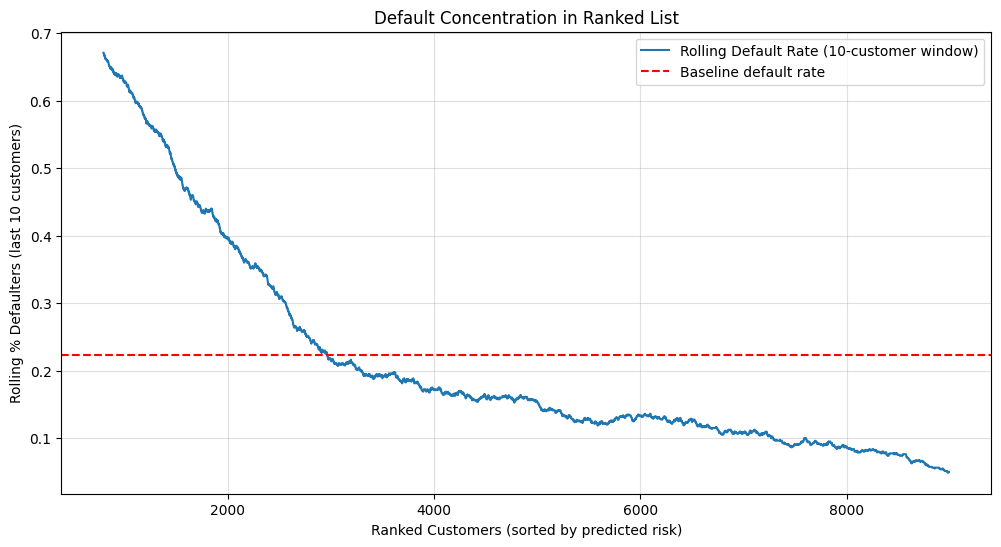

In [15]:
import matplotlib.pyplot as plt

window_size = 800  # rolling over 10 customers
rolling_default_rate = y_true_sorted.rolling(window=window_size).mean()


plt.figure(figsize=(12, 6))

plt.plot(
    rolling_default_rate.values,
    label="Rolling Default Rate (10-customer window)"
)

# Baseline average default rate in test set
plt.axhline(y=y_test.mean(), color="red", linestyle="--", label="Baseline default rate")

plt.xlabel("Ranked Customers (sorted by predicted risk)")
plt.ylabel("Rolling % Defaulters (last 10 customers)")
plt.title("Default Concentration in Ranked List")
plt.legend()
plt.grid(alpha=0.4)
plt.show()


On the left side (top-ranked, highest predicted risk), the default rate is far above the baseline (even >70% in the very top bins).

As you move to the right (lower-ranked, safer customers), the default rate falls toward the baseline (~22%).

This visually proves your model is successfully ranking risky customers first.

The rolling line plot is smoother but hides the local spikes; the scatter shows how concentrated defaults are in the top bins, which is exactly what lenders care about.
 
Why this is good

If you took the top 100 customers, a very large % would default → high lift.

If you randomly sampled 100 customers, you’d only see the baseline ~22%.

So this validates the lift / area ratio you computed: your model gives more “signal” early in the ranked list, which is what the paper measures.

In [16]:
import pandas as pd
import numpy as np

# Total number of customers
n = len(y_true_sorted)

# Total defaults
total_defaults = y_true_sorted.sum()

decile_results = []

# For each decile (10%, 20%, ..., 100%)
for d in range(5, 110, 5):
    cutoff = int((d/100) * n)  # number of customers in top d%
    captured_defaults = y_true_sorted.iloc[:cutoff].sum()
    captured_pct = (captured_defaults / total_defaults) * 100
    decile_results.append({"Top % Population": f"Top {d}%", 
                           "Defaults Captured (%)": round(captured_pct, 2)})

# Create table
decile_df = pd.DataFrame(decile_results)
print(decile_df)


   Top % Population  Defaults Captured (%)
0            Top 5%                  15.90
1           Top 10%                  29.67
2           Top 15%                  40.76
3           Top 20%                  49.60
4           Top 25%                  56.86
5           Top 30%                  61.93
6           Top 35%                  66.50
7           Top 40%                  70.53
8           Top 45%                  74.06
9           Top 50%                  77.58
10          Top 55%                  80.96
11          Top 60%                  83.50
12          Top 65%                  86.68
13          Top 70%                  89.17
14          Top 75%                  91.70
15          Top 80%                  94.09
16          Top 85%                  95.87
17          Top 90%                  97.66
18          Top 95%                  99.20
19         Top 100%                 100.00
20         Top 105%                 100.00


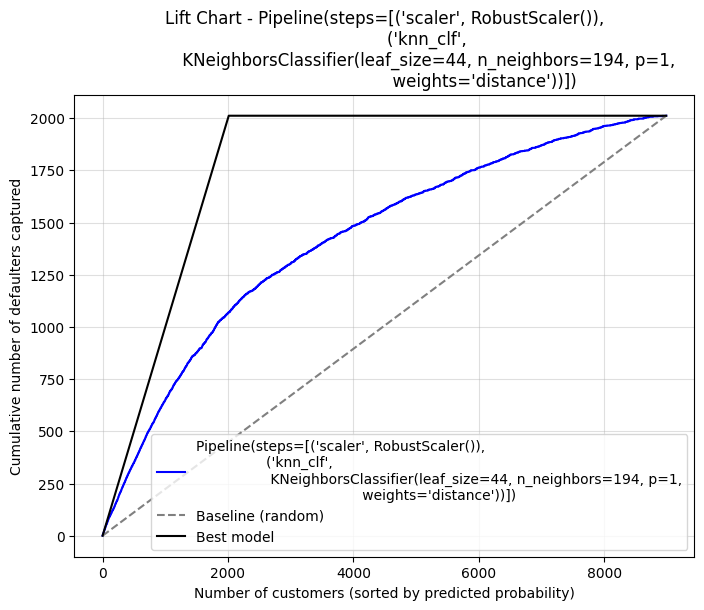

In [17]:
plot_lift_chart(y_test, y_test_proba_optimized, optimal_knn_pipeline)